# Ingestion

In [1]:
%run ingestion.ipynb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   facility      810 non-null    object 
 1   date          481 non-null    object 
 2   timeStart     810 non-null    object 
 3   timeEnd       481 non-null    object 
 4   supplierCode  481 non-null    object 
 5   suppliedM3    810 non-null    float64
 6   recoveredM3   810 non-null    float64
 7   processTime   329 non-null    object 
 8   supplier      329 non-null    object 
dtypes: float64(2), object(7)
memory usage: 57.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facility_code    810 non-null    int64         
 1   supplier_code    810 non-null    int64         
 2   start_date_time  810 non-null    datetime64[ns]
 

In [2]:
df

,facility_code,supplier_code,start_date_time,process_time,input,output,throughput
0,0,4,2022-08-01 08:29:00,2280.0,2.00,1.55,0.040789
1,0,5,2022-08-01 09:27:00,7260.0,6.80,4.15,0.034298
2,0,4,2022-08-01 11:38:00,2580.0,1.95,1.55,0.036047
3,0,6,2022-08-01 12:40:00,5040.0,3.95,2.55,0.030357
4,0,5,2022-08-01 14:25:00,7440.0,5.30,3.10,0.025000
...,...,...,...,...,...,...,...
805,0,6,2022-09-30 11:40:00,3660.0,3.70,2.35,0.038525
806,0,5,2022-09-30 12:52:00,6240.0,6.35,4.55,0.043750
807,1,1,2022-09-30 13:48:00,220.0,4.53,2.73,0.744545
808,0,4,2022-09-30 15:02:00,2400.0,2.00,1.45,0.036250


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facility_code    810 non-null    int64         
 1   supplier_code    810 non-null    int64         
 2   start_date_time  810 non-null    datetime64[ns]
 3   process_time     810 non-null    float32       
 4   input            810 non-null    float32       
 5   output           810 non-null    float32       
 6   throughput       810 non-null    float32       
dtypes: datetime64[ns](1), float32(4), int64(2)
memory usage: 31.8 KB


---
# Setup

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import (
    scatter_matrix
)

---
# Analysis

## Histgram per column

array([[<AxesSubplot: title={'center': 'facility_code'}>,
        <AxesSubplot: title={'center': 'supplier_code'}>,
        <AxesSubplot: title={'center': 'start_date_time'}>],
       [<AxesSubplot: title={'center': 'process_time'}>,
        <AxesSubplot: title={'center': 'input'}>,
        <AxesSubplot: title={'center': 'output'}>],
       [<AxesSubplot: title={'center': 'throughput'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

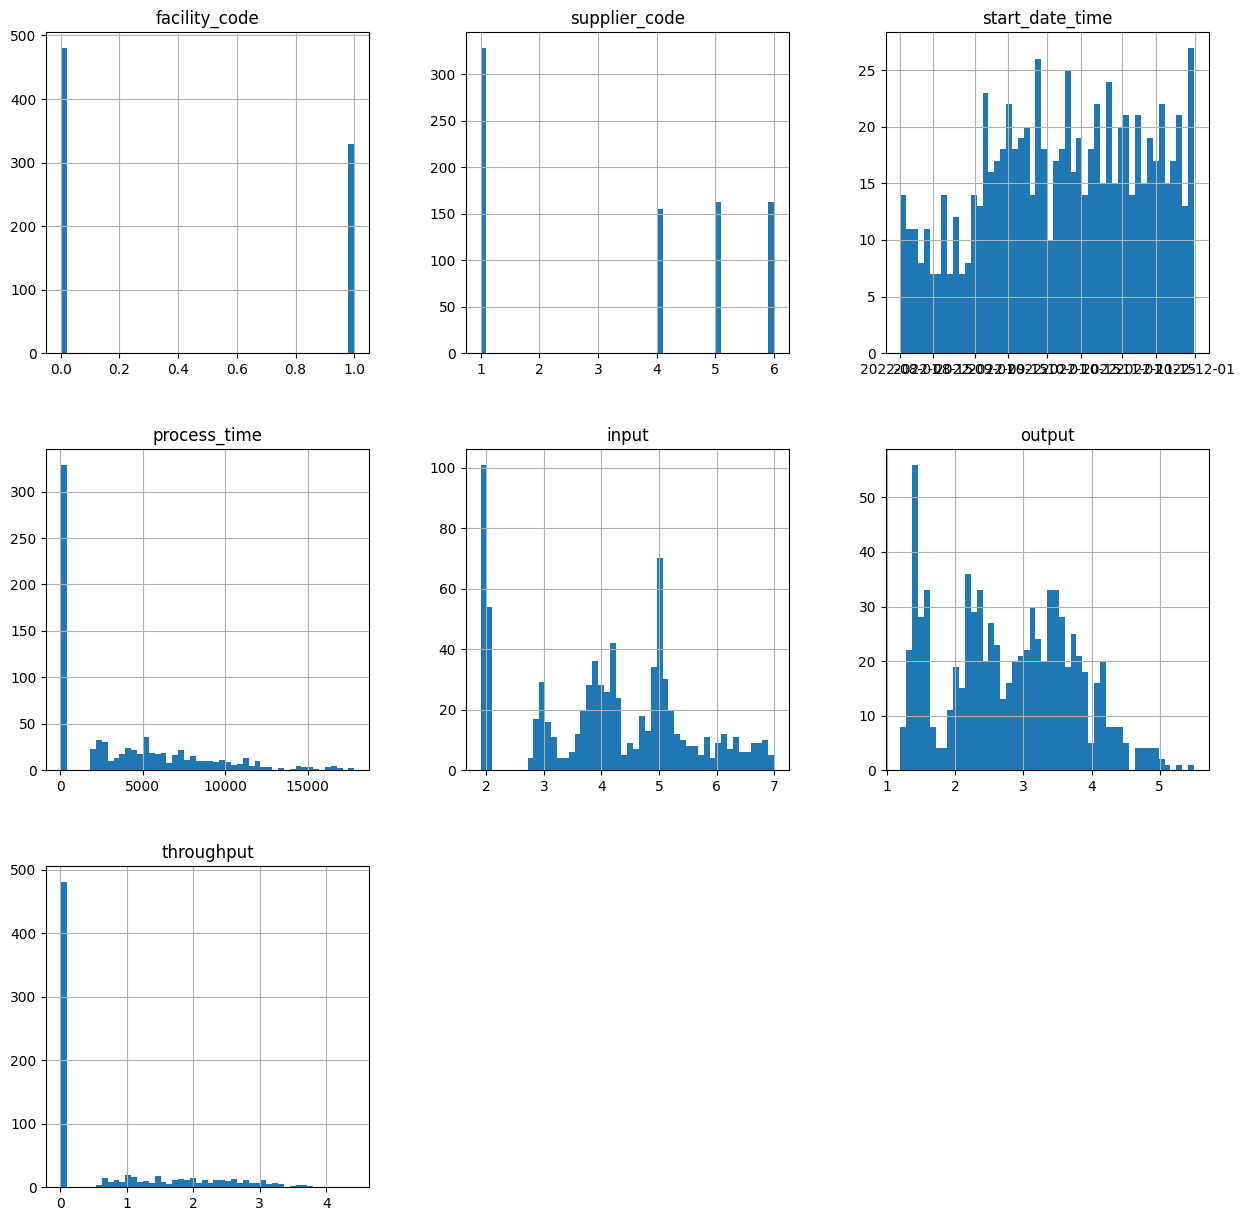

In [15]:
df.hist(bins=50, figsize=(15, 15))

## Correlations

In [6]:
correlations = df.corr()

/var/folders/_4/8v285hqs45xfzk0l1nlr3yq40000gn/T/ipykernel_82881/446670884.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()


In [7]:
correlations["facility_code"].sort_values(ascending=False)

facility_code    1.000000
throughput       0.866242
output           0.176723
input            0.075345
process_time    -0.754958
supplier_code   -0.953095
Name: facility_code, dtype: float64

In [8]:
attributes = [
    COLUMN_START_TIME, 
    COLUMN_PROCESS_TIME,
    COLUMN_INPUT,
    COLUMN_OUTPUT,
    COLUMN_THROUGHPUT,
]    

array([[<AxesSubplot: xlabel='process_time', ylabel='process_time'>,
        <AxesSubplot: xlabel='input', ylabel='process_time'>,
        <AxesSubplot: xlabel='output', ylabel='process_time'>,
        <AxesSubplot: xlabel='throughput', ylabel='process_time'>],
       [<AxesSubplot: xlabel='process_time', ylabel='input'>,
        <AxesSubplot: xlabel='input', ylabel='input'>,
        <AxesSubplot: xlabel='output', ylabel='input'>,
        <AxesSubplot: xlabel='throughput', ylabel='input'>],
       [<AxesSubplot: xlabel='process_time', ylabel='output'>,
        <AxesSubplot: xlabel='input', ylabel='output'>,
        <AxesSubplot: xlabel='output', ylabel='output'>,
        <AxesSubplot: xlabel='throughput', ylabel='output'>],
       [<AxesSubplot: xlabel='process_time', ylabel='throughput'>,
        <AxesSubplot: xlabel='input', ylabel='throughput'>,
        <AxesSubplot: xlabel='output', ylabel='throughput'>,
        <AxesSubplot: xlabel='throughput', ylabel='throughput'>]],
      dtype

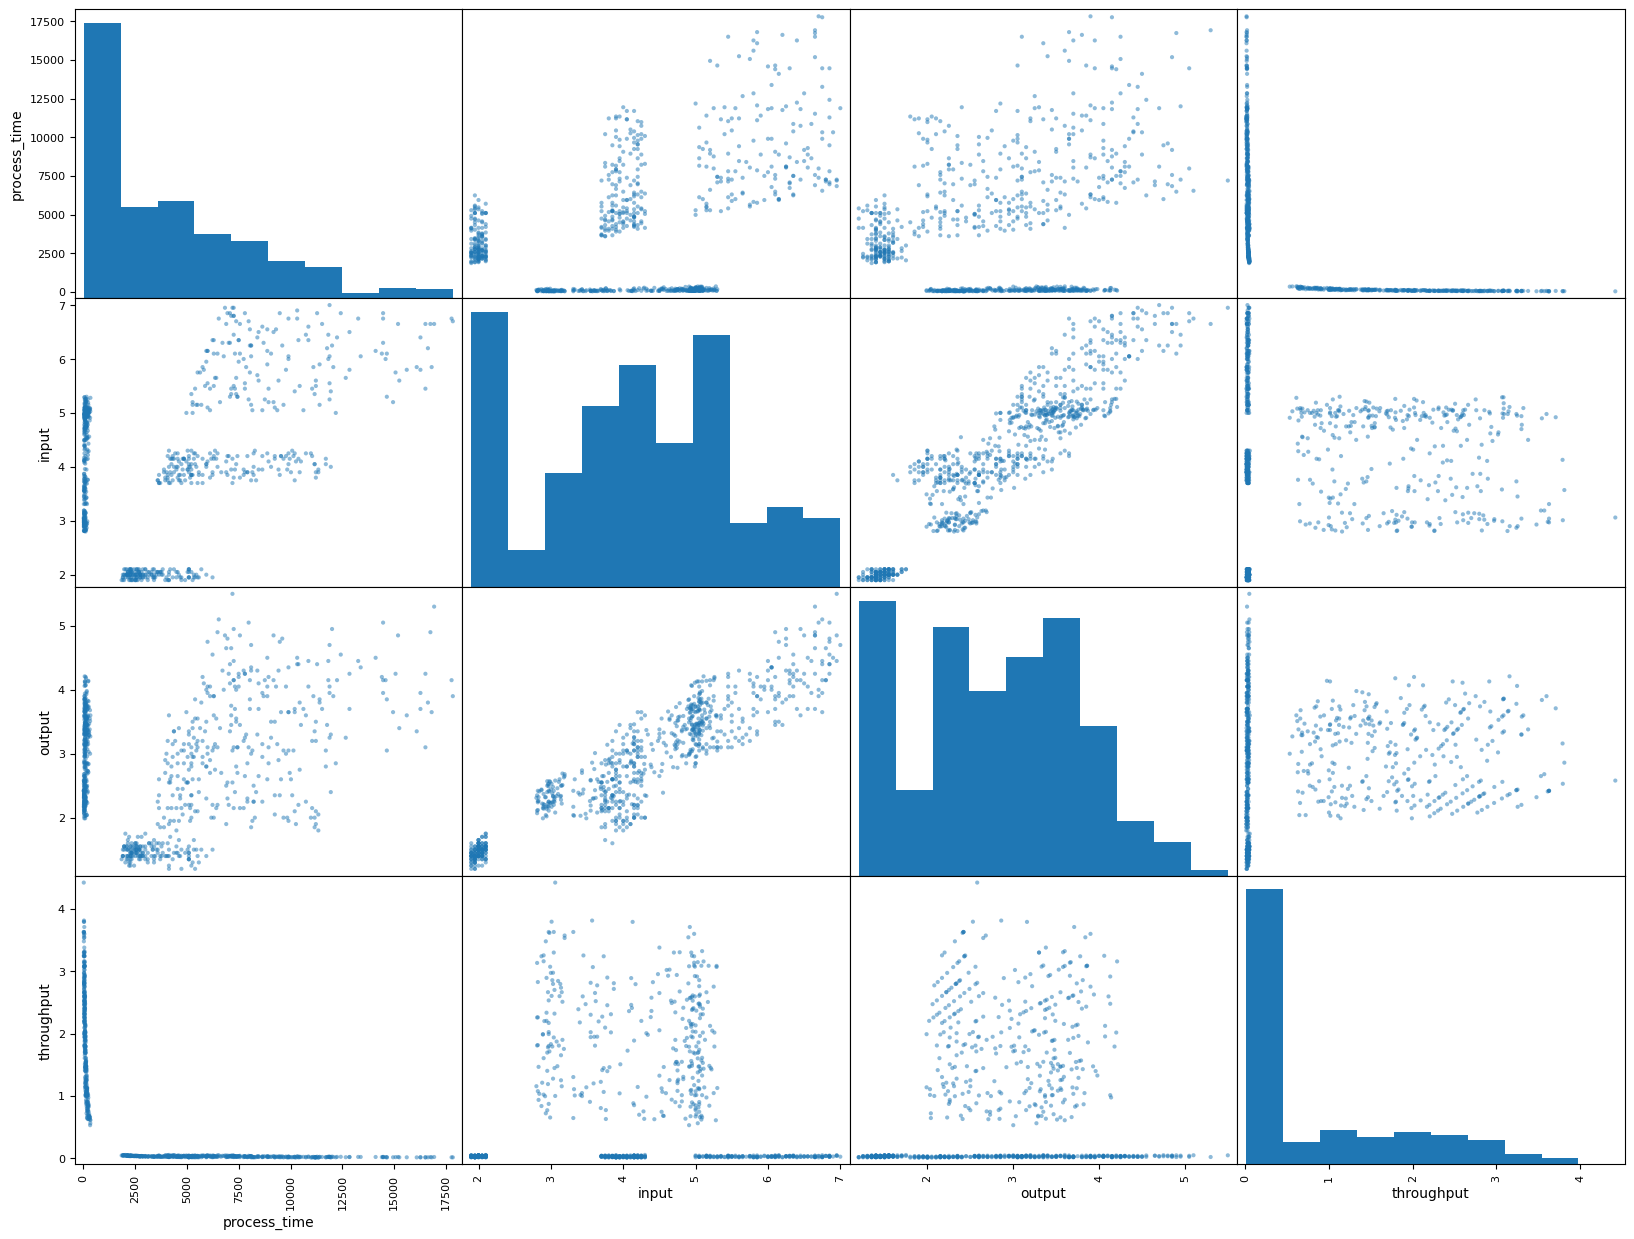

In [9]:
scatter_matrix(df[attributes], figsize=(20, 15))